# Local Sensitivity Analysis

This section demonstrates a post-optimality analysis using local sensitivity analysis based on finite difference gradients calculated using the surrogate of the objective and constraint function. The optimization problem used in this section is the modified Branin function problem also used in the Constrained Sequential Sampling section. The constrained minimum is $f(x^*) = 47.56$ at $x^* = (9.143, 3.281)$. The objective and constraint function can be stated as:

$$
    \begin{gathered}
        f(x_1, x_2) = \Bigg ( x_2 - \frac{5.1}{4\pi^2} x_1^2 + \frac{5}{\pi}x_1 - 6 \Bigg)^2 + 10 \Bigg( 1-\frac{1}{8\pi} \Bigg)\cos x_1 + 10 + 5x_1 \\
        g(x_1, x_2) = x_1x_2 \geq 30 \\
        -5 \leq x_1 \leq 10 \text{ and } 0 \leq x_2 \leq 15,
    \end{gathered}
$$

The code blocks below import the required packages, 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

def constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 30
    
    if dim == 1:
        g = g.reshape(-1)

    return g

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

Differential evolution (DE) from `pymoo` is used for maximizing EI. Below code defines problem class and initializes DE.

In [2]:
# Problem class
class ConstrainedEI(Problem):

    def __init__(self, sm_func, sm_const, ymin):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, xl=lb, xu=ub)

        self.sm_func = sm_func
        self.sm_const = sm_const
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        # Standard normal
        numerator = self.ymin - self.sm_func.predict_values(x)
        denominator = np.sqrt( self.sm_func.predict_variances(x) )
        z = numerator / denominator
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - ( numerator * normal.cdf(z) + denominator * normal.pdf(z) )
        out["G"] = self.sm_const.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs sequential sampling process using EI. The maximum number of iterations is set to 20 and a convergence criterion is defined based on maximum value of EI obtained in each iteration.

In [3]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Storing the final results
xstar = xbest[-1]
ystar = ybest[-1]
gstar = gtrain[index]


Iteration 1
Maximum EI: 110.63921985820126
Best observed value: 153.49765654383987

Iteration 2
Maximum EI: 102.10638946547952
Best observed value: 153.49765654383987

Iteration 3
Maximum EI: 98.4739990805927
Best observed value: 153.49765654383987

Iteration 4
Maximum EI: 96.65862468782339
Best observed value: 153.49765654383987

Iteration 5
Maximum EI: 96.42041361211108
Best observed value: 153.49765654383987

Iteration 6
Maximum EI: 96.41935943091737
Best observed value: 153.49765654383987

Iteration 7
Maximum EI: 96.41931310217768
Best observed value: 153.49765654383987

Iteration 8
Maximum EI: 96.419304512324
Best observed value: 153.49765654383987

Iteration 9
Maximum EI: 96.41928562725735
Best observed value: 153.49765654383987

Iteration 10
Maximum EI: 96.41928353677444
Best observed value: 153.49765654383987

Iteration 11
Maximum EI: 96.41928142277604
Best observed value: 153.49765654383987

Iteration 12
Maximum EI: 96.41927801038334
Best observed value: 153.49765654383987

I

The blocks of code below perform the post-optimality analysis at the optimum point that is found using sequential sampling using the gradients obtained using finite differences which is a local sensitivity analysis approach. 

In [58]:
def central_diff(x,h,index,func):
    """
        Function for computing multivariate central difference.
        Input:
        x - input at which derivative is desired
        h - step size
        func - python function which should return function value based on x.
    """

    delta = np.zeros(x.shape)
    delta[index] = 1
    x_plus = x + delta*h
    x_minus = x - delta*h
    slope = (func(x_plus.reshape(1,-1))) - func(x_minus.reshape(1,-1))/2/h
    return slope

# Calculating slopes from surrogates
x1_slope_surrogate = (xstar[0]/sm_func.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 0, func = sm_func.predict_values)
x2_slope_surrogate = (xstar[1]/sm_func.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 1, func = sm_func.predict_values)
print("Derivative of objective with respect to x1 from surrogate:", x1_slope_surrogate)
print("Derivative of objective with respect to x2 from surrogate:", x2_slope_surrogate)

# Calculating slopes from true function
x1_slope = (xstar[0]/modified_branin(xstar)) * central_diff(xstar, h = 0.1, index = 0, func = modified_branin)
x2_slope = (xstar[1]/modified_branin(xstar)) * central_diff(xstar, h = 0.1, index = 1, func = modified_branin)
print("Derivative of objective with respect to x1 from true function:", x1_slope)
print("Derivative of objective with respect to x2 from true function:", x2_slope)


Derivative of objective with respect to x1 from surrogate: [[-36.52839023]]
Derivative of objective with respect to x2 from surrogate: [[-13.03679635]]
Derivative of objective with respect to x1 from true function: [-36.52745123]
Derivative of objective with respect to x2 from true function: [-13.04045254]


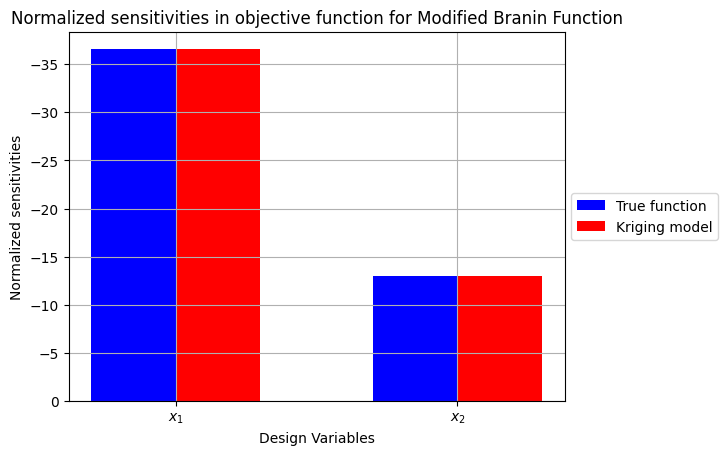

In [43]:
# Plotting objective sensitivities
vars = ['$x_1$','$x_2$']
slope_surrogate = np.array([x1_slope_surrogate.reshape(-1)[0], x2_slope_surrogate.reshape(-1)[0]])
slope_true = np.array([x1_slope[0], x2_slope[0]])
r = np.arange(len(slope_surrogate))
width = 0.3
fig, ax = plt.subplots()
ax.bar(r, slope_true, color ='blue', width = width, label = "True function")
ax.bar(r+width, slope_surrogate, color ='red', width = width, label = "Kriging model")
ax.set_xlabel("Design Variables")
ax.set_ylabel("Normalized sensitivities")
ax.set_title("Normalized sensitivities in objective function for Modified Branin Function")
ax.set_xticks(r + width/2,vars) 
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

In [36]:
def central_diff(x,h,index,func):
    """
        Function for computing multivariate central difference.
        Input:
        x - input at which derivative is desired
        h - step size
        func - python function which should return function value based on x.
    """

    delta = np.zeros(x.shape)
    delta[index] = 1
    x_plus = x + delta*h
    x_minus = x - delta*h
    slope = (func(x_plus.reshape(1,-1))) - func(x_minus.reshape(1,-1)) /2/h
    return slope

# Calculating slopes from surrogates
x1_slope_surrogate = (xstar[0]/sm_const.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 0, func = sm_const.predict_values)
x2_slope_surrogate = (xstar[1]/sm_const.predict_values(xstar.reshape(1,-1))) * central_diff(xstar, h = 0.1, index = 1, func = sm_const.predict_values)
print("Derivative of constraint with respect to x1 from surrogate:", x1_slope_surrogate)
print("Derivative of constraint with respect to x2 from surrogate:", x2_slope_surrogate)

# Calculating slopes from true function
x1_slope = (xstar[0]/constraint(xstar)) * central_diff(xstar, h = 0.1, index = 0, func = constraint)
x2_slope = (xstar[1]/constraint(xstar)) * central_diff(xstar, h = 0.1, index = 1, func = constraint)
print("Derivative of constraint with respect to x1 from true function:", x1_slope)
print("Derivative of constraint with respect to x2 from true function:", x2_slope)

Derivative of constraint with respect to x1 from surrogate: [[25616593.40922132]]
Derivative of constraint with respect to x2 from surrogate: [[25608246.54591248]]
Derivative of constraint with respect to x1 from true function: [15796367.77443987]
Derivative of constraint with respect to x2 from true function: [15796391.22788259]


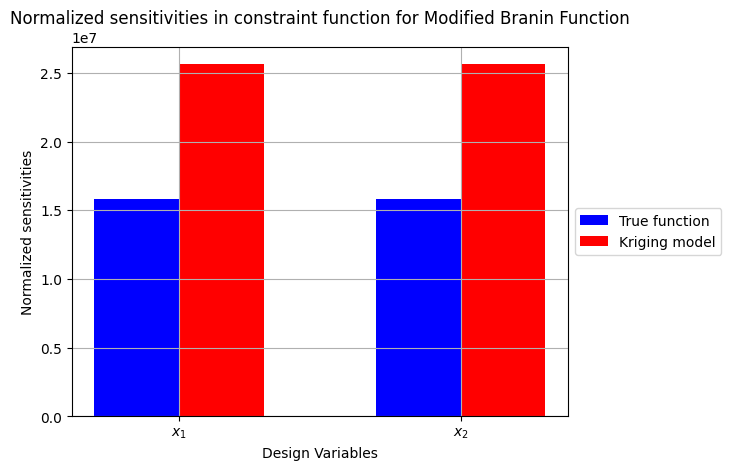

In [37]:
# Plotting constraint sensitivities
vars = ['$x_1$','$x_2$']
slope_surrogate = np.array([x1_slope_surrogate.reshape(-1)[0], x2_slope_surrogate.reshape(-1)[0]])
slope_true = np.array([x1_slope[0], x2_slope[0]])
r = np.arange(len(slope_surrogate))
width = 0.3
fig, ax = plt.subplots()
ax.bar(r, abs(slope_true), color ='blue', width = width, label = "True function")
ax.bar(r+width, abs(slope_surrogate), color ='red', width = width, label = "Kriging model")
ax.set_xlabel("Design Variables")
ax.set_ylabel("Normalized sensitivities")
ax.set_title("Normalized sensitivities in constraint function for Modified Branin Function")
ax.set_xticks(r + width/2,vars) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()

In [49]:
def relaxed_constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 29
    
    if dim == 1:
        g = g.reshape(-1)

    return g

In [54]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 10
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = relaxed_constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, relaxed_constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Change in objective function
print("Change in f* with one unit reduction in constraint limit:", ybest[-1] - ystar)


Iteration 1
Maximum EI: 6.184123205820542
Best observed value: 48.640516711623135

Iteration 2
Maximum EI: 6.28268309941965
Best observed value: 48.640516711623135

Iteration 3
Maximum EI: 6.259582251862996
Best observed value: 48.640516711623135

Iteration 4
Maximum EI: 0.5133697703895117
Best observed value: 48.640516711623135

Iteration 5
Maximum EI: 1.069603623862199
Best observed value: 48.640516711623135

Iteration 6
Maximum EI: 0.05436643464515678
Best observed value: 47.4497371020886

Iteration 7
Maximum EI: 0.09022509834140495
Best observed value: 47.4497371020886

Iteration 8
Maximum EI: 3.406132250410318e-14
Best observed value: 47.347523066344436

Best feasible point:
x*: [9.14867665 3.16987103]
f*: 47.347523066344436
g*: -0.00012512165594458224
Change in f* with one unit reduction in constraint limit: -0.21243421340051327


In [55]:
def tight_constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 31
    
    if dim == 1:
        g = g.reshape(-1)

    return g

In [56]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 10
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = tight_constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, tight_constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))

# Change in objective function
print("Change in f* with one unit reduction in constraint limit:", ybest[-1] - ystar)


Iteration 1
Maximum EI: 12.088966241726782
Best observed value: 62.82865173276025

Iteration 2
Maximum EI: 2.4995361074411164
Best observed value: 51.95274714504929

Iteration 3
Maximum EI: 0.3360167119785135
Best observed value: 51.95274714504929

Iteration 4
Maximum EI: 0.399547967367583
Best observed value: 47.838426413538585

Iteration 5
Maximum EI: 0.03375045746064582
Best observed value: 47.838426413538585

Iteration 6
Maximum EI: 0.00183775633290394
Best observed value: 47.795124705207385

Iteration 7
Maximum EI: 9.992352408347921e-08
Best observed value: 47.795124705207385

Best feasible point:
x*: [9.17590348 3.37845804]
f*: 47.795124705207385
g*: -0.00040491583522594965
Change in f* with one unit reduction in constraint limit: 0.23516742546243563


In [29]:
ystar

47.55995727974495

In [30]:
ybest[-1]

47.608488472945716